# LeNet-5 (1998, Yan LeCunn)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Activation, Input

from tensorflow.keras.datasets import mnist
np.random.seed(101)

### train, test split

In [2]:
# MNIST 숫자 이미지 데이터셋 로드
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 각 데이터셋의 형태 출력
print(X_train.shape)  # (60000, 28, 28) → 6만 개의 28x28 픽셀 흑백 이미지
print(y_train.shape)  # (60000,) → 각 이미지에 대한 정답(0~9 숫자)
print(X_test.shape)   # (10000, 28, 28) → 테스트용 1만 개 이미지
print(y_test.shape)   # (10000,)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


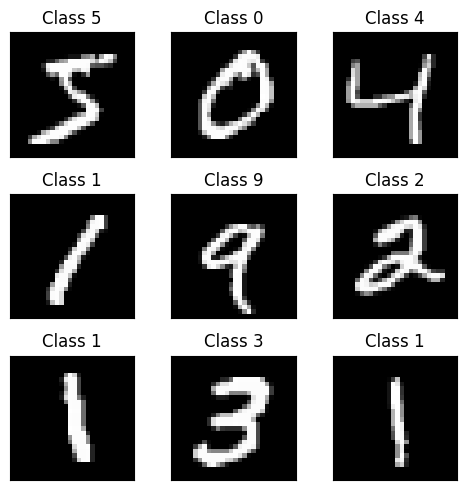

In [3]:
# 5x5 크기의 전체 그림 틀 생성
plt.figure(figsize=(5,5))

# 처음 9개의 학습 이미지 시각화
for i in range(9):
    plt.subplot(3, 3, i+1)  # 3행 3열 레이아웃의 i+1번째 위치에 그래프 배치
    plt.imshow(X_train[i], cmap='gray', interpolation='none')  # 흑백 이미지 표시
    plt.title("Class {}".format(y_train[i]))  # 해당 이미지의 숫자 클래스 표시
    plt.xticks([])  # x축 눈금 제거
    plt.yticks([])  # y축 눈금 제거

# 그래프 간 여백 자동 조정
plt.tight_layout()

# 그래프 출력
plt.show()

### scaling 
- 0 `~` 1 사이로 pixel 값을 scale

In [4]:
# 픽셀 값을 0~1 사이로 정규화 (원래는 0~255 사이 정수값)
X_train_scaled = X_train / 255.
X_test_scaled = X_test / 255.

### Conv2D layer 의  입력 사양에 맞추어 3 dimension 으로 차원 증가

In [5]:
# 차원 확장: (28, 28) → (28, 28, 1)
# 흑백 이미지에 채널 차원(axis=3)을 추가하여 CNN 입력 형식에 맞춤
X_train_scaled = np.expand_dims(X_train_scaled, axis=3)
X_test_scaled = np.expand_dims(X_test_scaled, axis=3)

In [6]:
X_train_scaled.shape, X_test_scaled.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

### label 을 one-hot-encoding

In [7]:
# 정수형 클래스 레이블을 One-hot 인코딩 형식으로 변환
# 예: 3 → [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)

## tf.data 를 이용한 shuffling and batch 구성

In [10]:
# 학습 데이터를 TensorFlow Dataset 객체로 변환
# - 데이터를 섞고(shuffle), 배치 단위로 나누어(batch) 학습에 사용
train_ds = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train_onehot)).shuffle(10000).batch(128)      # 배치 크기: 128

# 테스트 데이터도 Dataset 객체로 변환 (섞지 않고 배치 처리만)
test_ds = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test_onehot)).batch(128)

## LeNet 구성

<img src="https://d2l.ai/_images/lenet.svg" width="800" />

In [11]:
# Sequential 모델 생성
model = tf.keras.Sequential()

# 입력층: 28x28 크기의 흑백 이미지 (채널 1개)
model.add(Input(shape=(28, 28, 1))) 

# 첫 번째 Conv2D 층: 6개의 5x5 필터, 출력 크기 유지 (padding="same")
model.add(Conv2D(6, kernel_size=5, padding="same"))
model.add(Activation('relu'))  # ReLU 활성화 함수
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))  # 2x2 최대 풀링

# 두 번째 Conv2D 층: 16개의 5x5 필터, 출력 크기 축소 (padding="valid")
model.add(Conv2D(16, kernel_size=5, padding="valid"))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# 평탄화(Flatten): 2차원 feature map → 1차원 벡터로 변환
model.add(Flatten())

# 완전 연결층 (Dense Layer)
model.add(Dense(120))
model.add(Activation ('relu'))

model.add(Dense(84))
model.add(Activation ('relu'))

# 출력층: 클래스 수 10개 (0~9), softmax로 확률 출력
model.add(Dense(10))
model.add(Activation ('softmax'))

# 모델 구조 요약 출력
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 6)           │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 28, 28, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 10, 10, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 84)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# 모델 컴파일: 손실 함수, 옵티마이저, 평가 지표 설정
model.compile(
    loss="categorical_crossentropy",   # 다중 클래스 분류를 위한 손실 함수 (One-hot 레이블에 사용)
    optimizer='adam',                  # Adam 옵티마이저 (적응형 학습률로 빠르고 안정적인 학습)
    metrics=['accuracy']               # 모델 성능 지표로 정확도 사용
)

In [13]:
# 모델 학습 수행
history = model.fit(
    train_ds,               # 학습용 데이터셋 (tf.data.Dataset 형식)
    epochs=5,               # 전체 데이터를 5회 반복 학습
    validation_data=test_ds # 검증 데이터셋 (모델 성능 평가용)
)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8173 - loss: 0.6093 - val_accuracy: 0.9696 - val_loss: 0.0878
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9735 - loss: 0.0887 - val_accuracy: 0.9804 - val_loss: 0.0620
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9819 - loss: 0.0599 - val_accuracy: 0.9858 - val_loss: 0.0425
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9870 - loss: 0.0451 - val_accuracy: 0.9834 - val_loss: 0.0530
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9874 - loss: 0.0388 - val_accuracy: 0.9862 - val_loss: 0.0422


In [14]:
# 테스트 데이터셋을 사용해 모델 성능 평가
# verbose=0 → 출력 생략 (조용하게 실행)
score = model.evaluate(test_ds, verbose=0)

In [15]:
print("Test Score ", score[0])
print("Test Accuracy ", score[1])

Test Score  0.042228758335113525
Test Accuracy  0.9861999750137329


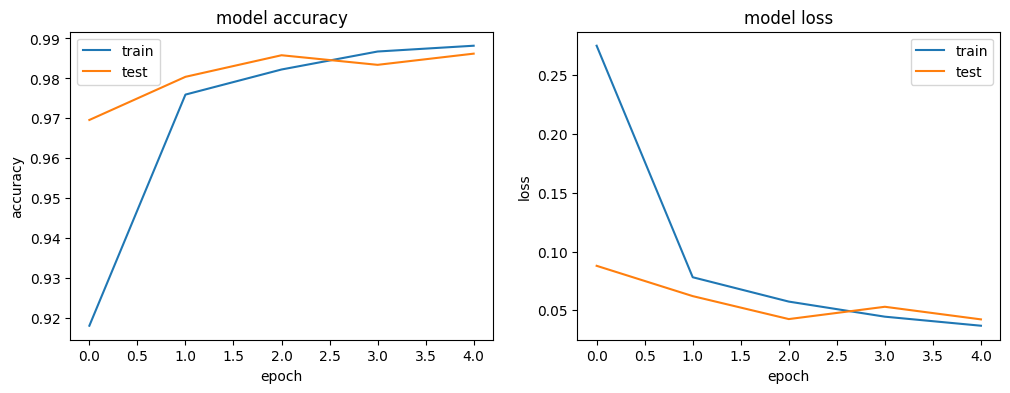

In [16]:
# 학습 과정 동안의 정확도와 손실을 시각화

plt.figure(figsize=(12, 4))  # 전체 그래프 크기 설정 (가로 12, 세로 4)

# 정확도 그래프 (왼쪽)
plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째 그래프
plt.plot(history.history['accuracy'])         # 학습 정확도
plt.plot(history.history['val_accuracy'])     # 검증 정확도
plt.title('model accuracy')                   # 제목
plt.xlabel('epoch')                           # 에포크(반복 횟수)
plt.ylabel('accuracy')                        # 정확도
plt.legend(['train', 'test'])                 # 범례

# 손실(loss) 그래프 (오른쪽)
plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째 그래프
plt.plot(history.history['loss'])             # 학습 손실
plt.plot(history.history['val_loss'])         # 검증 손실
plt.title('model loss')                       # 제목
plt.xlabel('epoch')                           # 에포크
plt.ylabel('loss')                            # 손실 값
plt.legend(['train', 'test'])                 # 범례

In [17]:
# 모델을 사용해 테스트 이미지에 대한 예측 수행
# model.predict()는 각 클래스(0~9)에 대한 확률을 반환 → shape: (10000, 10)
# .argmax(axis=1)을 통해 가장 확률이 높은 클래스의 인덱스(즉, 예측 레이블) 추출
y_pred = model.predict(X_test_scaled).argmax(axis=1)
y_pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


array([7, 2, 1, ..., 4, 5, 6])

In [18]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score

# 혼동 행렬 출력: 실제 값(y_test) vs 예측 값(y_pred)
print(confusion_matrix(y_test, y_pred))

[[ 973    1    0    0    2    0    2    2    0    0]
 [   0 1133    1    0    0    0    0    1    0    0]
 [   1    2 1022    0    1    0    0    6    0    0]
 [   0    0    2 1002    0    2    0    2    0    2]
 [   0    0    1    0  980    0    0    0    0    1]
 [   2    1    0    7    0  873    3    1    1    4]
 [   2    4    1    0    6    3  942    0    0    0]
 [   0    2    3    1    4    0    0 1016    0    2]
 [   4    0    8    9    5    0    1    2  941    4]
 [   0    0    0    2   18    2    0    7    0  980]]


Test Accuracy : 0.9862


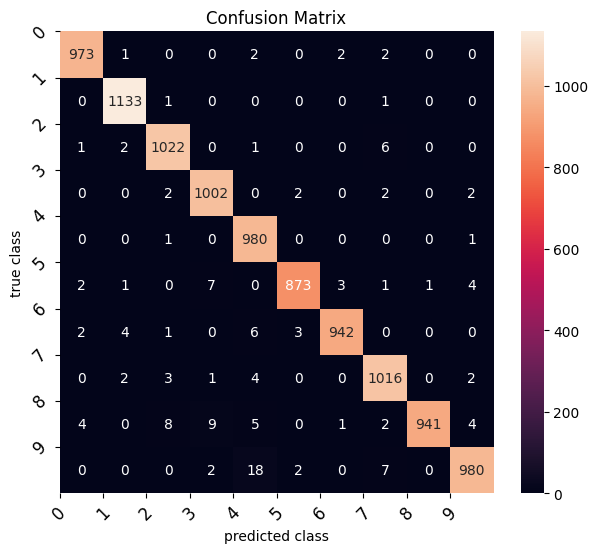

In [21]:
import seaborn as sns

plt.figure(figsize=(7, 6))  # 그래프 크기 설정

# 혼동 행렬 생성 및 시각화
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')

# x, y축 눈금 라벨 설정 (클래스 0~9)
plt.xticks(np.arange(10), list(range(10)), rotation=45, fontsize=12)
plt.yticks(np.arange(10), list(range(10)), rotation=45, fontsize=12)

# 축 라벨 및 제목 설정
plt.xlabel("predicted class")   # 예측된 클래스
plt.ylabel("true class")        # 실제 클래스
plt.title('Confusion Matrix')   # 그래프 제목

# 정확도 출력
print('Test Accuracy :', accuracy_score(y_test, y_pred))

# 실습 : fashion MNIST 를 이용하여 위와 동일한 작업

Label	Class  
0	T-shirt/top  
1	Trouser  
2	Pullover  
3	Dress  
4	Coat  
5	Sandal  
6	Shirt  
7	Sneaker  
8	Bag  
9	Ankle boot

In [20]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation

np.random.seed(102)

In [22]:
# 패션 MNIST 데이터셋 로드 (훈련용/테스트용 자동 분리)
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# 각 데이터셋의 형상 출력
print(train_images.shape)   # (60000, 28, 28) → 6만 개의 28x28 흑백 이미지
print(train_labels.shape)   # (60000,) → 각 이미지의 레이블 (0~9 범주)
print(test_images.shape)    # (10000, 28, 28) → 1만 개 테스트 이미지
print(test_labels.shape)    # (10000,) → 테스트 이미지의 레이블

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [23]:
# 패션 MNIST 데이터셋의 레이블(정수값 0~9)을 사람이 이해할 수 있는 클래스 이름으로 매핑
class_names = [
    'T-shirt/top',   # 0
    'Trouser',       # 1
    'Pullover',      # 2
    'Dress',         # 3
    'Coat',          # 4
    'Sandal',        # 5
    'Shirt',         # 6
    'Sneaker',       # 7
    'Bag',           # 8
    'Ankle boot'     # 9
]

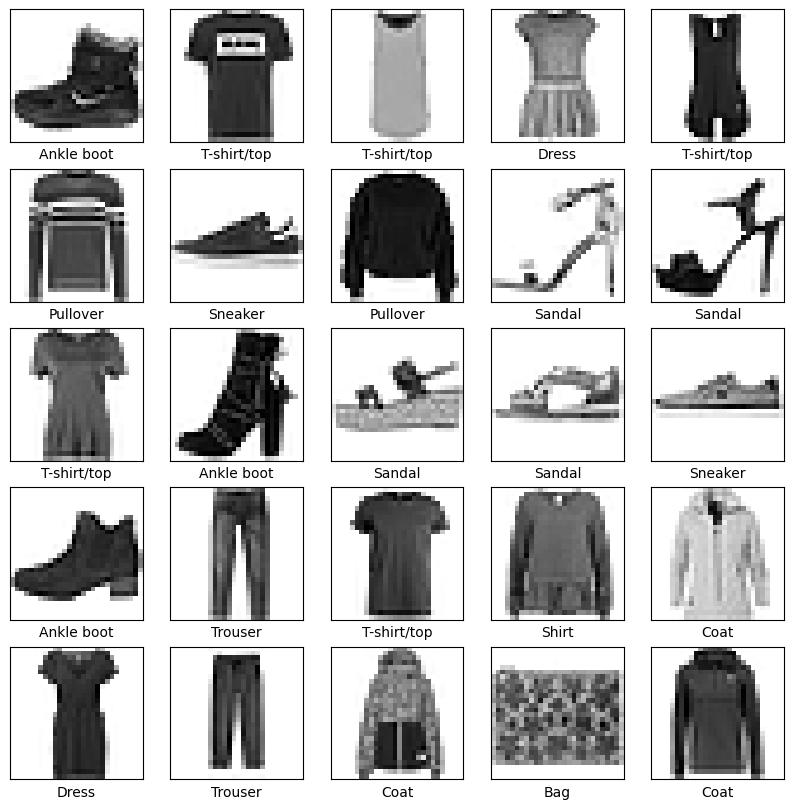

In [24]:
# 훈련 이미지 중 처음 25장을 5x5 격자로 시각화
plt.figure(figsize=(10, 10))  # 전체 그림 크기 설정

for i in range(25):
    plt.subplot(5, 5, i+1)  # 5행 5열 중 i+1번째 위치에 그림 배치
    plt.imshow(train_images[i], cmap=plt.cm.binary)  # 흑백 이미지로 출력
    plt.xlabel(class_names[train_labels[i]])  # x축에 클래스 이름 표시
    plt.xticks([])  # x축 눈금 제거
    plt.yticks([])  # y축 눈금 제거

In [25]:
# 픽셀 값을 0~1 사이로 정규화
# 원래 픽셀 값은 0~255 범위의 정수 → 255로 나누어 실수화
X_train = train_images / 255.0
X_test  = test_images / 255.0

In [25]:
# Conv2D layer 의  입력 사양에 맞추어 3 dimension 으로 차원 증가

In [26]:
# label 을 one-hot-encoding

In [27]:
# tf.data 를 이용한 shuffling and batch 구성

In [28]:
# LeNet model 구성

In [29]:
# model compile and predict

In [30]:
# train history 시각화

In [31]:
# confusion matrix 시각화